In [2]:
import xarray as xr
import aostools.climate as aos
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [3]:
# variables = ['u', 'v', 't']
# files = []

# for var in variables:
#     blah = glob.glob(f'/gws/nopw/j04/arctic_connect/xum/ECMWF/ERA5/Daily/{var}/*.nc')
    
#     for element in blah:
#         files.append(element)
        
# print(len(files))

# # ds = xr.open_mfdataset(files, parallel=True, chunks={'time': 5397}) # chunks separates into 3 groups of 5397

# ds = xr.open_mfdataset(files, parallel=True, chunks={'longitude': 45})
# ds.attrs = {}  # for brevity, hide attributes
# ds = ds.drop_vars('time_bnds')
# ds

In [ ]:
ds = xr.open_dataset('/gws/nopw/j04/arctic_connect/cturrell/era5_data/era5daily_uvt.nc', parallel=True)
ds

In [9]:
import datetime as dt

ds = ds.sel(time=ds.time.dt.month.isin([12,1,2]))
ds

# ds.to_netcdf('/gws/nopw/j04/arctic_connect/cturrell/era5_data/era5daily_djf_uvt.nc')

<xarray.Dataset>
Dimensions:    (time: 4030, longitude: 360, latitude: 181, level: 37)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T09:00:00 ... 2023-02-28T09:00:00
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * level      (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
Data variables:
    t          (time, level, latitude, longitude) float32 dask.array<chunksize=(31, 37, 181, 45), meta=np.ndarray>
    u          (time, level, latitude, longitude) float32 dask.array<chunksize=(31, 37, 181, 45), meta=np.ndarray>
    v          (time, level, latitude, longitude) float32 dask.array<chunksize=(31, 37, 181, 45), meta=np.ndarray>

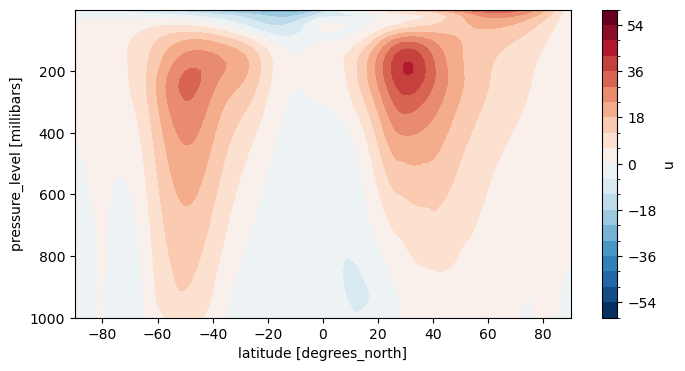

In [11]:
# compute zonal mean zonal wind
ubar = ds.u.mean(('time','longitude'))

ubar.plot.contourf(levels=20, yincrease=False, yscale='linear', figsize=(8,4))

In [12]:
# Solve EP flux
ep1, ep2, div1, div2 = aos.ComputeEPfluxDivXr(ds.u, ds.v, ds.t, 
                                              lon='longitude', lat='latitude', pres='level', time='time', do_ubar=True)

In [13]:
ds['ep1'] = (ep1.dims, ep1.values)
ds['ep2'] = (ep2.dims, ep2.values)
ds['div1'] = (div1.dims, div1.values)
ds['div2'] = (div2.dims, div2.values)
ds['ubar'] = (ubar.dims, ubar.values)
ds

<xarray.Dataset>
Dimensions:    (time: 4030, longitude: 360, latitude: 181, level: 37)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T09:00:00 ... 2023-02-28T09:00:00
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * level      (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
Data variables:
    t          (time, level, latitude, longitude) float32 dask.array<chunksize=(31, 37, 181, 45), meta=np.ndarray>
    u          (time, level, latitude, longitude) float32 dask.array<chunksize=(31, 37, 181, 45), meta=np.ndarray>
    v          (time, level, latitude, longitude) float32 dask.array<chunksize=(31, 37, 181, 45), meta=np.ndarray>
    ep1        (time, level, latitude) float64 -0.0 4.17 9.309 ... nan nan nan
    ep2        (time, level, latitude) float64 -0.0 -4.057e-05 ... nan nan
    div1       (time, level, latitude) float64 -2.862 -10.09 -9.264 ... nan nan
    div2       (time, level, latitude) float64 0.0 -1.171 -1.964 ... nan nan nan
    ubar       (level, latitude) float32 -0.000153 2.097 ... -0.292 1.856e-05

In [ ]:
# skip variables
skip_lat = 8
skip_pres = 2

skip = dict( latitude=slice(None, None, skip_lat), level=slice(None, None, skip_pres) )

# set variables
lat = ds3.latitude.isel(dict(latitude=slice(None, None, skip_lat)))
p = ds3.level.isel(dict(level=slice(None, None, skip_pres)))
Fphi = ds3.ep1.mean(('time')).isel(skip)
Fp = ds3.ep2.mean(('time')).isel(skip)

fig, ax = plt.subplots(figsize=(9,5))

coolwarm = sns.color_palette("coolwarm", as_cmap=True)
RB = sns.color_palette('RdBu_r', as_cmap=True)

plt.contourf(ds3.latitude.values, ds3.level.values, ubar3,
              cmap=coolwarm, levels=15)
plt.colorbar(location='bottom', orientation='horizontal', shrink=0.5,
             label='Wind speed (m/s)')

aos.PlotEPfluxArrows(lat, p, Fphi, Fp,
                     fig, ax, pivot='mid', yscale='log')
plt.title('Zonal-mean zonal wind and EP fluxes using ERA5 daily data')
plt.xlabel('Latitude ($^\\circ$N)')
plt.ylabel('Log pressure (hPa)')
plt.show()

In [ ]:
rename = {'latitude': 'lat', 'longitude':'lon'}
ds

## Diagnosing Issues

In [ ]:
# ds1 = ds.sel(level=1000.)
# ds1.ep1.mean(('time')).plot.line()

In [ ]:
# ds1.ep2.mean(('time')).plot.line()

In [ ]:
# ds1.latitude

In [ ]:
# ds2 = ds1.isel(latitude=slice(40, 140))
# ds2.latitude

# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# ds2.ep1.mean(('time')).plot.scatter(ax=ax1)
# ds2.ep2.mean(('time')).plot.scatter(ax=ax2)
# plt.show()

In [ ]:
# ds3 = ds.isel(level=slice(0, 36))
# ds3.level

# ubar3 = ds3.u.mean(('time', 'longitude'))

In [ ]:
# # try ubar=False

# # Solve EP flux
# ep1a, ep2a, div1a, div2a = aos.ComputeEPfluxDivXr(ds.u, ds.v, ds.t, 
#                                               lon='longitude', lat='latitude', pres='level', time='time', do_ubar=True)

# ds['ep1'] = (ep1.dims, ep1.values) 
# ds['ep2'] = (ep2.dims, ep2.values) 

## Playing with Seaborn colour palettes

In [ ]:
sns.palplot(sns.color_palette('Blues', 20))

In [ ]:
sns.color_palette('RdBu_r', as_cmap=True)

In [ ]:
sns.color_palette("coolwarm", as_cmap=True)

In [ ]:
sns.color_palette("coolwarm", 20)